# HW 1

## Import libraries



In [1]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import seaborn as sns # visualization library
import sklearn as sk
import matplotlib.pyplot as plt # another visualization library
import warnings
warnings.filterwarnings('ignore')

## Part 1 - load the data

In [2]:
file = 'virus_hw2.csv'

In [3]:
df = pd.read_csv(file)

## Part 2 - Fix the data types

Fixing CurrentLocation lat long type - separate into 2 features

In [4]:

label_categories = [
    'not_detected_Spreader_NotatRisk',
    'not_detected_NotSpreader_atRisk',
    'not_detected_NotSpreader_NotatRisk',
    'not_detected_Spreader_atRisk',
    'cold_NotSpreader_NotatRisk',
    'cold_Spreader_NotatRisk',
    'cold_Spreader_atRisk',
    'cold_NotSpreader_atRisk',
    'flue_NotSpreader_NotatRisk',
    'flue_NotSpreader_atRisk',
    'flue_Spreader_NotatRisk',
    'covid_NotSpreader_atRisk',
    'covid_Spreader_NotatRisk',
    'flue_Spreader_atRisk',
    'covid_NotSpreader_NotatRisk',
    'covid_Spreader_atRisk',
    'cmv_NotSpreader_NotatRisk',
    'cmv_Spreader_atRisk',
    'cmv_NotSpreader_atRisk',
    'cmv_Spreader_NotatRisk',
    'measles_Spreader_NotatRisk',
    'measles_NotSpreader_NotatRisk',
    'measles_NotSpreader_atRisk',
    'measles_Spreader_atRisk',
]

convert_dict = {
    'Address': str,
    'BloodType': pd.CategoricalDtype(categories=['AB-', 'A+', 'AB+', 'A-', 'B-', 'O-', 'B+', 'O+']),
    'Job': str,
    'SyndromeClass': pd.CategoricalDtype(categories=range(1,5)),
    'TestResultsCode': pd.CategoricalDtype(categories=label_categories),
}

df = df.astype(convert_dict)

### Handle Sex

In [5]:
df.replace({'Sex': {'F': -1, 'M': 1}}, inplace=True)

### Handle BloodType

In [6]:
df = pd.get_dummies(df, columns=["BloodType"], prefix=["BloodType"])


### Handle DateOfPCRTest

In [7]:
df['DateOfPCRTest'] = pd.to_datetime(df['DateOfPCRTest'], infer_datetime_format=True) 
df['DateOfPCRTest'] = df['DateOfPCRTest'].values.astype(float)
df['DateOfPCRTest'].values[df['DateOfPCRTest'].values < 0] = np.nan

### Handle SyndromeClass

In [8]:
df = pd.get_dummies(df, columns=["SyndromeClass"], prefix=["SyndromeClass"])


### Handle location

we separate the location into 2 features for longitude and latitude.

In [9]:
long_lat_df = df['CurrentLocation'].str.strip('(Decimal').str.split(', ', expand=True).rename(columns={0:'Lat', 1:'Long'}) 
df['CurrentLocation_Lat'] = long_lat_df['Lat'].str.strip("')")
df['CurrentLocation_Long'] = long_lat_df['Long'].str.strip("Decimal('").str.rstrip("'))")

convert_dict = {
    'CurrentLocation_Lat': float,
    'CurrentLocation_Long': float,
}

df = df.astype(convert_dict)
df.drop(labels=['CurrentLocation'], axis=1, inplace=True)

### Handle symptoms

We create a one-hot vector of all symptoms and remove the old mixed feature.

In [10]:

splitted_df = df['SelfDeclarationOfIllnessForm'].str.split(';', expand=True)
values = splitted_df.values.flatten()
unique_values = pd.unique(values).tolist()
stripped_unique_values = [str(val).strip(' ') for val in unique_values]

# Split by ; to create a list for each row
df['SelfDeclarationOfIllnessForm_list'] = df['SelfDeclarationOfIllnessForm'].str.split(';')

# Replace NAN values with empty list
isna = df['SelfDeclarationOfIllnessForm_list'].isna()
df.loc[isna, 'SelfDeclarationOfIllnessForm_list'] = pd.Series([['nan']] * isna.sum()).values

# strip whitespaces
df['SelfDeclarationOfIllnessForm_list'] = [[str(val).strip() for val in list(symptom_list)] for symptom_list in df['SelfDeclarationOfIllnessForm_list'].values]

# Create columns
for column_name in stripped_unique_values:
    df[column_name] = pd.Series([1 if column_name in row else 0 for row in df['SelfDeclarationOfIllnessForm_list']])


# Rename no symptoms column
df.rename(columns={'nan': 'No_Symptoms'}, inplace=True)

# Drop irrelevant features
df.drop(labels=['SelfDeclarationOfIllnessForm','SelfDeclarationOfIllnessForm_list'], axis=1, inplace=True)


## Part 3 - Transformations


### Imputation

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [12]:
df["TimeOnSocialActivities"]

0       71.096219
1       59.209984
2       27.962990
3       49.786640
4       76.434326
          ...    
4995    86.454184
4996    59.502008
4997    42.730383
4998    54.735153
4999    37.348102
Name: TimeOnSocialActivities, Length: 5000, dtype: float64

In [13]:
numeric_features = [
    'AvgHouseholdExpenseOnPresents', 
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult1',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult14',
    'pcrResult15',
    'pcrResult16',
    'CurrentLocation_Lat',
    'CurrentLocation_Long']
    
numeric_transformer = SimpleImputer(strategy='mean', missing_values=np.nan)

categorical_features = [
    'AgeGroup',
    'DisciplineScore', 
    'HappinessScore', 
    'Sex',
]

categorical_transformer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

imputer = make_column_transformer((numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder='drop'
)

dfi = pd.DataFrame(imputer.fit_transform(df), columns=numeric_features+categorical_features)
dtypes = df.dtypes.to_dict()
df.update(dfi, overwrite=False)
df = df.astype(dtypes)

In [14]:
df.isna().sum()

PatientID                           0
Address                             0
AgeGroup                            0
AvgHouseholdExpenseOnPresents       0
AvgHouseholdExpenseOnSocialGames    0
                                   ..
Muscle_or_body_aches                0
Chills                              0
Skin_redness                        0
New_loss_of_taste_or_smell          0
Sore_throat                         0
Length: 61, dtype: int64

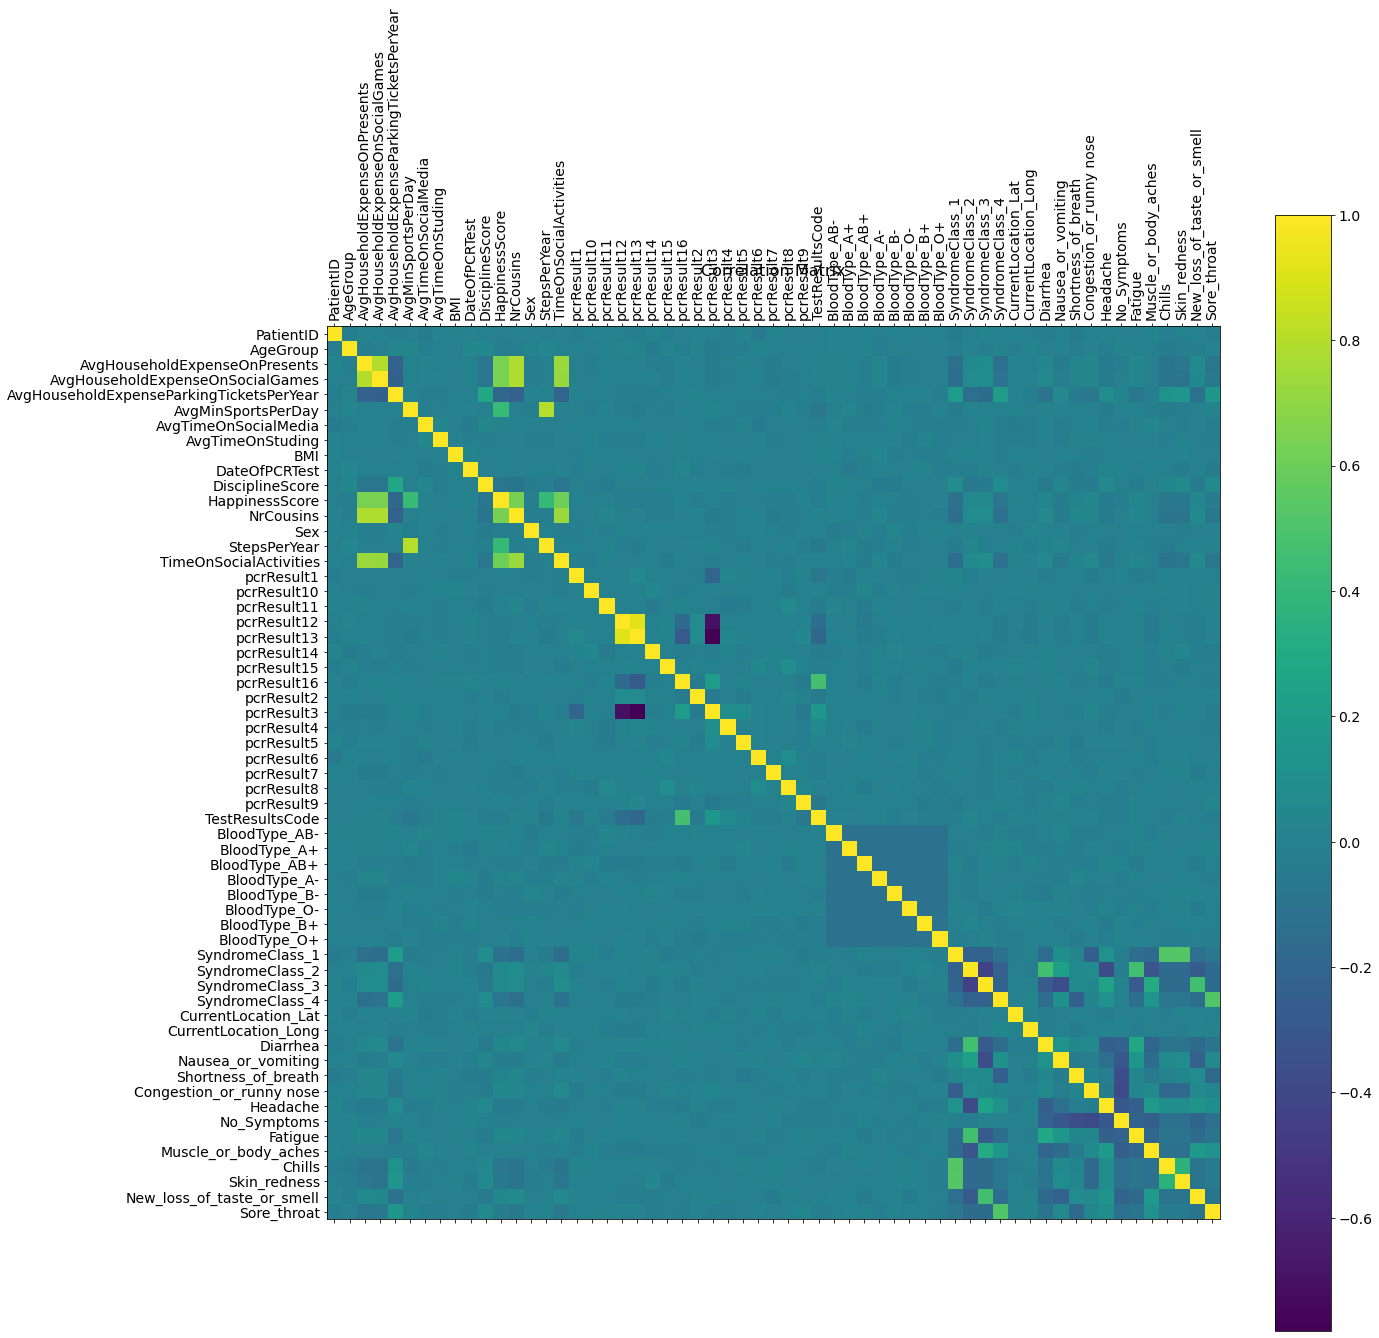

In [114]:
df_copy = df.copy()
df_copy.update(df[['TestResultsCode']].apply(lambda x : x.cat.codes))
df_copy = df_copy.astype({'TestResultsCode': int})

corr = df_copy.corr()
corr.to_csv('corr.csv')
columns = df_copy.drop(labels=['Address','Job'], axis=1)
f = plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(columns.shape[1]), columns.columns, fontsize=14, rotation=90)
plt.yticks(range(columns.shape[1]), columns.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()
a = 0

### Outlier Detection


In [15]:
df['BloodType_AB-'].value_counts()

0    4466
1     534
Name: BloodType_AB-, dtype: int64

In [117]:
# from scipy import stats

# df[stats.zscore(df >= 3).all(axis=1)]

In [ ]:
class OutlierClipper:
    def __init__(self):
        self._feature_map = {}

    def fit(self, data):
        features = list(data.columns)
        for feature in features:
            f_q1 = data[feature].quantile(0.25)
            f_q3 = data[feature].quantile(0.75)
            f_iqr = f_q3 - f_q1
            self._feature_map[feature] = (f_q1 - (1.5 * f_iqr), f_q3 + (1.5 * f_iqr))
        return self

    def transform(self, data):
        data_copy = data.copy()
        for feature in self._feature_map.keys():
            data_copy[feature] = data_copy[feature].clip(lower=self._feature_map[feature][0],
                                                         upper=self._feature_map[feature][1])
        return data_copy

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [ ]:
continous_features = ['StepsPerYear',
                    'TimeOnSocialActivities',
                    'AvgHouseholdExpenseOnPresents',
                    'AvgHouseholdExpenseOnSocialGames',
                    'AvgHouseholdExpenseParkingTicketsPerYear',
                    'AvgMinSportsPerDay',
                    'AvgTimeOnSocialMedia',
                    'AvgTimeOnStuding',
                    'BMI',
                    'pcrResult1',
                    'pcrResult10',
                    'pcrResult11',
                    'pcrResult12',
                    'pcrResult13',
                    'pcrResult14',
                    'pcrResult15',
                    'pcrResult16',
                    'pcrResult2',
                    'pcrResult3',
                    'pcrResult4',
                    'pcrResult5',
                    'pcrResult6',
                    'pcrResult7',
                    'pcrResult8',
                    'pcrResult9']

In [ ]:
outlier_clipper = OutlierClipper()
df[continous_features] = outlier_clipper.fit_transform(df[continous_features])
df.describe().to_csv('after_clipping.csv')

## Normalization

In [115]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

positive_scaled_features = ['AgeGroup',
    'AvgHouseholdExpenseOnPresents',
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'DisciplineScore',
    'HappinessScore',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult14',
    'pcrResult16']
minMaxScaler = MinMaxScaler()
df[positive_scaled_features] = minMaxScaler.fit_transform(df[positive_scaled_features])

negative_scaled_features = [
    'pcrResult1',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult15',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
]
maxAbsScale = MaxAbsScaler()
df[negative_scaled_features] = maxAbsScale.fit_transform(df[negative_scaled_features])

df['CurrentLocation_Lat'] /= 180
df['CurrentLocation_Long'] /= 180

